In [8]:
'''  Clinical dataset being filtered for the purpose of survival resulting in 942 unique cases. This will be used to get the appropriate patchesin training and testing sets '''
import pandas as pd
import numpy as np
cols=["case_submitter_id","days_to_birth","days_to_death","vital_status","year_of_birth","year_of_death","age_at_diagnosis","days_to_diagnosis","days_to_last_follow_up","year_of_diagnosis","treatment_or_therapy"]
df = pd.read_csv("clinical.tsv",usecols=cols, sep='\t')
temp1=pd.get_dummies(df["vital_status"])
df2 = pd.concat((df,temp1),axis=1)
df2 = df2.drop(['vital_status'],axis=1)
df2 = df2.drop(['Alive'],axis=1)
df2['Dead'] = df2['Dead'].astype(int)
df2 = df2.drop_duplicates()
df2 = df2.replace("'--", np.nan)
df2['event_data'] = df2['days_to_death']
df2.event_data.fillna(df2.days_to_last_follow_up, inplace=True)
df2 = df2[df2['event_data'].notna()]
df2['duration_months'] = np.round(df2['event_data'].astype(int)/31)
df2['duration_months']=df2['duration_months'].astype(int)
df2=df2.sort_values(["duration_months"], ascending=True)
df3 = df2[['case_submitter_id', 'Dead', 'event_data','duration_months']].copy()
df3.reset_index(drop=True, inplace=True)
df3=df3.drop_duplicates()
len(df3)

942

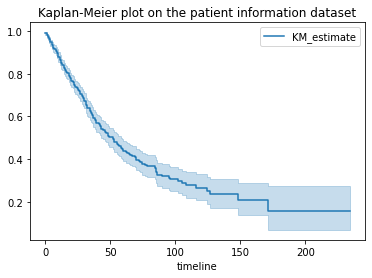

In [5]:
''' Kaplan-Meier plot of the filtered dataset to visualize the survival rates based on event duration '''
!pip install lifelines
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
kmf = KaplanMeierFitter()
T = df3["duration_months"]
E = df3["Dead"]
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.title('Kaplan-Meier plot on the patient information dataset');

In [6]:
''' Function to generate 5 folds of training and test splits in such a way that the event durations are uniformly distributed '''
def get_folds_bins(frame, n_bins=5, eps=1e-6, num_folds=5):
    def get_folds_event_data(frame, k, event_col):
        # Copy and sort by event times.
        df = frame.copy(deep=True)
        df = df.reindex(np.random.permutation(df.index)).sort_values(event_col)
        n, _ = df.shape

        # Fold assigments for each row entry.
        assignments = np.array((n // k + 1) * list(range(1, k + 1)))
        assignments = assignments[:n]

        # Get fold patients.
        folds = list()
        for i in range(1, k+1):
            ix = assignments == i
            training_data = df.loc[~ix]
            test_data     = df.loc[ix]
            training_pat  = pd.unique(training_data.case_submitter_id).tolist()
            test_pat  = pd.unique(test_data.case_submitter_id).tolist()
            folds.append((training_pat,test_pat))
        return folds

    frame_working = frame.copy(deep=True)
    uncensored_df = frame_working[frame_working.Dead== 1]

    disc_labels, q_bins = pd.qcut(uncensored_df['duration_months'], q=n_bins, retbins=True, labels=False)
    q_bins[-1] = frame_working['duration_months'].max() + eps
    q_bins[0] = frame_working['duration_months'].min() - eps

    disc_labels, q_bins = pd.cut(frame_working['duration_months'], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True)
    frame_working.insert(2, 'label', disc_labels.values.astype(int))

    total_folds = dict()
    for i in range(num_folds):
        total_folds[i] = dict()
        total_folds[i]['train'] = list()
        total_folds[i]['valid'] = list()
        total_folds[i]['test'] = list()

    for i in range(len(q_bins)-1):
        bin_censored   = frame_working[(frame_working.label==i)&(frame_working.Dead==0)]
        bin_uncensored = frame_working[(frame_working.label==i)&(frame_working.Dead==1)]
        bin_folds_censored   = get_folds_event_data(frame=bin_censored,   k=num_folds, event_col='duration_months')
        bin_folds_uncensored = get_folds_event_data(frame=bin_uncensored, k=num_folds, event_col='duration_months')

        for i in range(num_folds):
            total_folds[i]['train'].extend([pat for pat in bin_folds_censored[i][0]] + [pat for pat in bin_folds_uncensored[i][0]])
            total_folds[i]['test'].extend([pat for pat in bin_folds_censored[i][1]] + [pat for pat in bin_folds_uncensored[i][1]]) 
    return total_folds

791
792
802
810
796


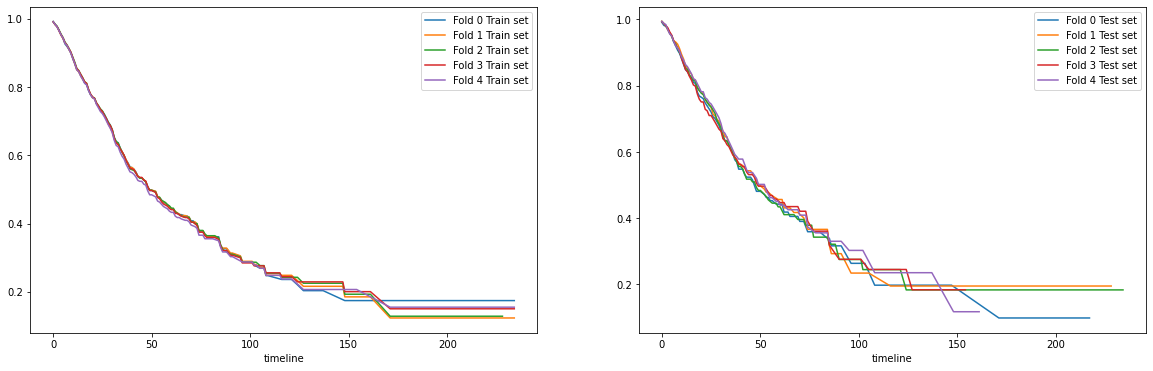

In [7]:
''' Test plot with repititve calls to "get_fols_bin" function '''
import numpy as np
import matplotlib.pyplot as plt
t=get_folds_bins(df2)[4]['train']
fin=pd.DataFrame()
t
f = plt.figure(figsize=(20,6))
ax4 = f.add_subplot(121)
ax5 = f.add_subplot(122)
for i in t:
    fin=fin.append(df2[df2['case_submitter_id'] == i])
#print(fin)

for i in range(5):
    train_data=get_folds_bins(df2)[i]['train']
    print(len(train_data))
    test_data=get_folds_bins(df2)[i]['test']
    train=pd.DataFrame()
    test=pd.DataFrame()
    for x in train_data:
        train=train.append(df2[df2['case_submitter_id'] == x])
    for y in test_data:
        test=test.append(df2[df2['case_submitter_id'] == y])
    kmf.fit(train['duration_months'], event_observed=train['Dead'], label="Fold %d Train set"%i)
    kmf.survival_function_.plot(ax=ax4)
    kmf.fit(test['duration_months'], event_observed=test['Dead'], label="Fold %d Test set"%i)
    kmf.survival_function_.plot(ax=ax5)
   
    



In [29]:
data=get_folds_bins(df3)


Train 751
Test 191
Train 751
Test 191
Train 752
Test 190
Train 755
Test 187
Train 759
Test 183


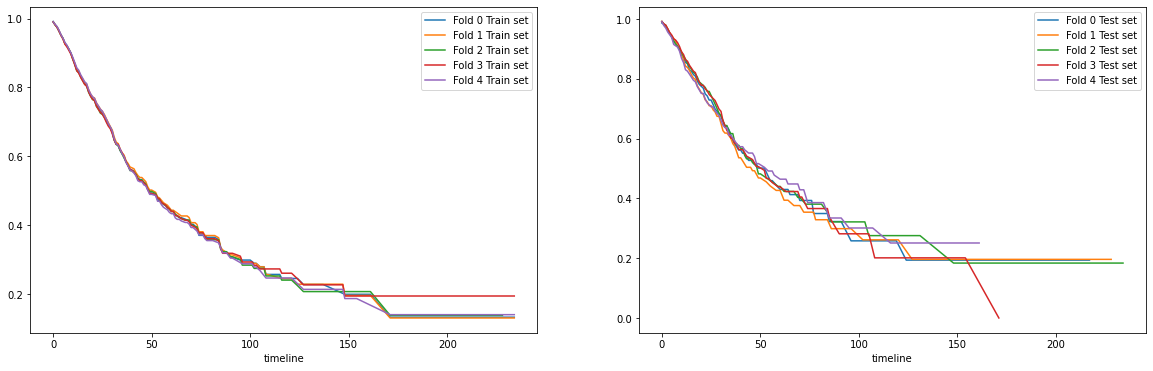

In [30]:
''' Kaplan-Meier plots of the 5 folds generated to portray how uniformly distributed they are with respect to event duration '''
import h5py
import numpy as np
import matplotlib.pyplot as plt
f = plt.figure(figsize=(20,6))
ax4 = f.add_subplot(121)
ax5 = f.add_subplot(122)
train_link="hdf5_TCGAFFPE_LUAD_5x_perP_he_train.h5"
test_link="hdf5_TCGAFFPE_LUAD_5x_perP_he_test.h5"
valid_link="hdf5_TCGAFFPE_LUAD_5x_perP_he_validation.h5"
hdf5_train = h5py.File(train_link, "r")
hdf5_test = h5py.File(test_link, "r")
hdf5_valid = h5py.File(valid_link, "r")
train_dset = hdf5_train['train_img']
test_dset = hdf5_test['test_img']
valid_dset = hdf5_valid['valid_img']
train_slides = hdf5_train['train_slides']
test_slides = hdf5_test['test_slides']
valid_slides = hdf5_valid['valid_slides']
for i in range(5):
    train_data=data[i]['train']
    print("Train",len(train_data))
    test_data=data[i]['test']
    print("Test",len(test_data))
    train=pd.DataFrame()
    test=pd.DataFrame()
    for x in train_data:
        train=train.append(df2[df2['case_submitter_id'] == x])
    for y in test_data:
        test=test.append(df2[df2['case_submitter_id'] == y])
    kmf.fit(train['duration_months'], event_observed=train['Dead'], label="Fold %d Train set"%i)
    kmf.survival_function_.plot(ax=ax4)
    kmf.fit(test['duration_months'], event_observed=test['Dead'], label="Fold %d Test set"%i)
    kmf.survival_function_.plot(ax=ax5)
